In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, max_error, median_absolute_error, r2_score

# Make figures larger
%matplotlib inline
plt.rc("figure", figsize=(16,6))
plt.rc("font", size=15)

print("pandas Version: " + pd.__version__)
print("numpy Version: " + np.__version__)
print("statsmodels Version: " + sm.__version__)

pandas Version: 1.2.4
numpy Version: 1.18.5
statsmodels Version: 0.12.2


In [34]:
df = pd.read_csv("../../data/clean/trips.csv", parse_dates=["date_from", "date_until"])
df.set_index("date_until", inplace=True)
df.head(3)

,bike_id,user_id,date_from,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,time_since_last_checkout
date_until,,,,,,,,,,,,
2014-01-01 00:20:04,119911,341973A96CDE0DF9792F6C844622735AE4216EBF,2014-01-01 00:02:51,Enckeplatz / Hütten,131887,Königstraße / Struenseestraße,131650,Terminal HH_8 (-2624-),18,2.364129,7.880431,NaN
2014-01-01 00:10:48,118994,665D79F269FA03F84FC61F3A7F7B078D7392EC0E,2014-01-01 00:07:45,Isestraße / Hoheluftbrücke,140804,Isestraße / Hoheluftbrücke,140804,Terminal HH_63 (-2241-),4,0.000000,0.000000,NaN
2014-01-01 00:26:20,143660,B46B52FDC494E46849DB84BF84F0B99C78358E59,2014-01-01 00:09:55,Schulterblatt/Eifflerstraße,131648,Schulterblatt/Eifflerstraße,131648,Android SRH,17,0.000000,0.000000,NaN


In [35]:
TRAIN_SIZE = 0.8
TEST_SIZE = 1.0 - TRAIN_SIZE

SAMPLE_START_DATE = "2016-05-01"
SAMPLE_END_DATE = "2016-05-13 23:59:59" # 13 days
#SAMPLE_END_DATE = "2016-05-14 23:59:59" # 14 days

ADF_P_THRESHOLD = 0.05

In [36]:
sample_df = df[["end_station_id"]]
sample_df = sample_df.resample("H").count()
sample_df = sample_df.rename(columns={ "end_station_id": "check_ins" })
sample_df = sample_df[pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)]
sample_df.head(3)

,check_ins
date_until,
2016-05-01 00:00:00,230
2016-05-01 01:00:00,244
2016-05-01 02:00:00,205


In [37]:
train_data, test_data = train_test_split(
    sample_df, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

df_steps = len(sample_df)
train_steps = len(train_data)
test_steps = len(test_data)

In [38]:
def print_statistics():
    y_true = test_data.check_ins.values
    y_pred = sarima_predictions.predicted_mean.values
    
    print("Order: %s"%str(order))
    print("Seasonal order: %s"%str(seasonal_order))
    
    print("DF steps: %s"%df_steps)
    print("Train steps: %s"%train_steps)
    print("Test steps: %s"%test_steps)

    print("MAPE: %s" %(mean_absolute_percentage_error(y_true, y_pred)))
    print("RMSE: %s" %(mean_squared_error(y_true, y_pred, squared=False)))
    print("MedAE: %s" %(median_absolute_error(y_true, y_pred)))
    print("Max error: %s" %(max_error(y_true, y_pred)))
    print("R2 score: %s" %(r2_score(y_true, y_pred)))

## Building a SARIMA model

### Plot data for first examination

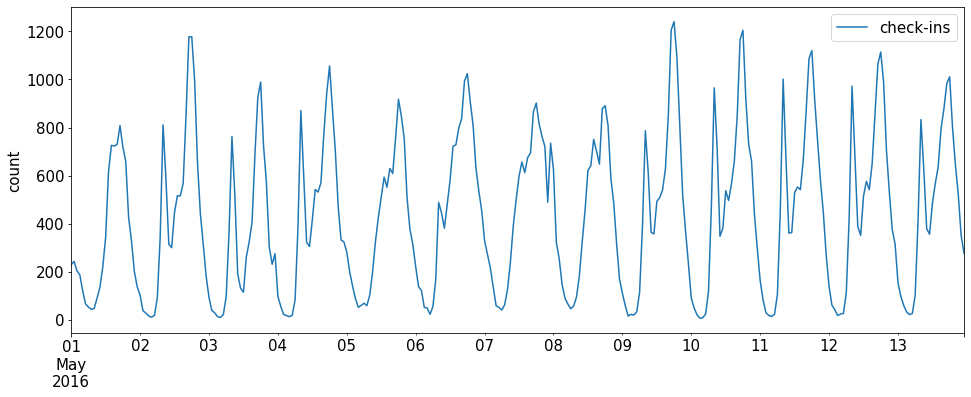

In [41]:
sample_df.plot()
plt.xlabel("")
plt.ylabel("count")
plt.legend(["check-ins"])
plt.savefig("../../figures/sarima_plot_%s_steps.pdf"%test_steps, bbox_inches="tight")
plt.show()

### Check if the data is stationary with an ADF test

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Test stationarity with the *Augmented Dickey-Fuller* test for every data set. Data is stationary if the `p` value is lower than the threshold `ADF_P_THRESHOLD` and the test statistics value is negative and lower than the critical value for 1%.

In [24]:
def check_stationarity(input_df):
    adf_result = adfuller(input_df)
    stats = adf_result[0]
    p_value = adf_result[1]
    crit1 = adf_result[4]["1%"]
    stationary = (
        p_value < ADF_P_THRESHOLD
    ) and (
        (stats < 0) and (stats < crit1)
    )
    data = {
        "stats": [stats],
        "p_value": [p_value],
        "crit1": [crit1],
        "stationary": [stationary]
    }
    return pd.DataFrame(data)

In [25]:
check_stationarity(sample_df)

,stats,p_value,crit1,stationary
0,-6.970594,8.685309e-10,-3.451017,True


The check-in data is stationary for all data sets and therefore does not require differenciation when predicting with an ARIMA model. Therefore the `d` parameter can be set to 0.

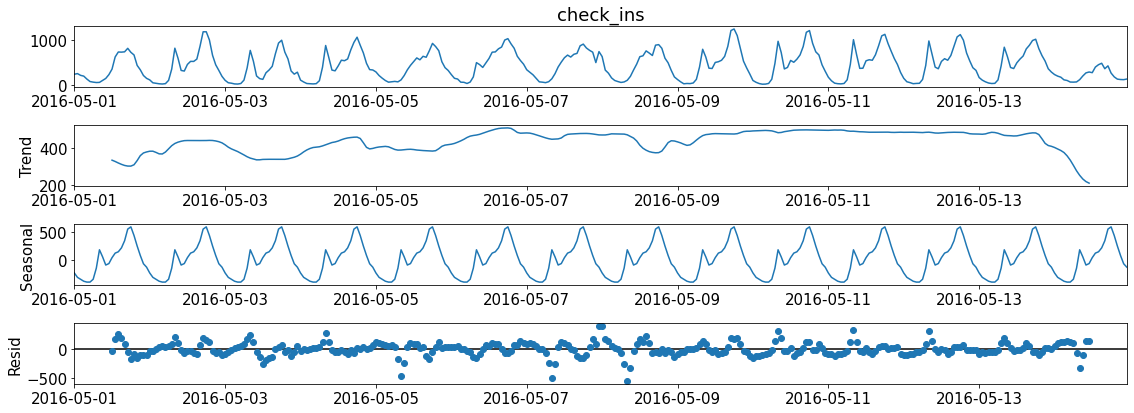

In [26]:
seasonal_decompose(sample_df.check_ins, period=24).plot()
plt.show()

### Check-in predictions for the next n hours overall

* Since data is seasonal, a SARIMA `(p,d,q)(P,D,Q)[S]` model will be used.
* Stationarity can be tested with the ADF method
* After applying differencing, if the ACF at lag 1 is -0.5 or more negative, the series may be overdifferenced

Rule of thumbs for parameters:

* `p` is equal to the first lag of the PACF plot that is still above the significance level, maybe one less
* `q` is equal to the first lag of the ACF plot that is still above the significance level, maybe one less
* `d` is 0 if the series has no visible trend or if the ACF at all lags is low

* `S` is equal to the ACF lag with the highest value / the amount of steps where a season is repeating
* `P` is >= 1 if the ACF is positive at lag `S`, else 0
* `D` is 1 if the seasonal pattern is stable over time, else 0
* `Q` is >= 1 if the ACF is negative at lag `S`, else 0

* `d`+`D` should be <= 2
* `P`+`Q` should be <= 2
* `p`+`d`+`q`+`P`+`D`+`Q` should be <= 6

In [27]:
# Resampling to set the frequency 'H' at the index again that is lost when using 'train_test_split'
# Prevents warning later on
train_data = train_data.resample("H").sum()
test_data = test_data.resample("H").sum()

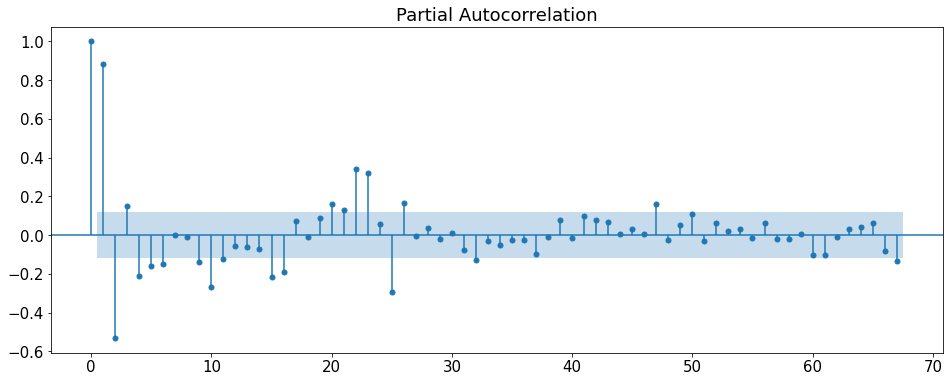

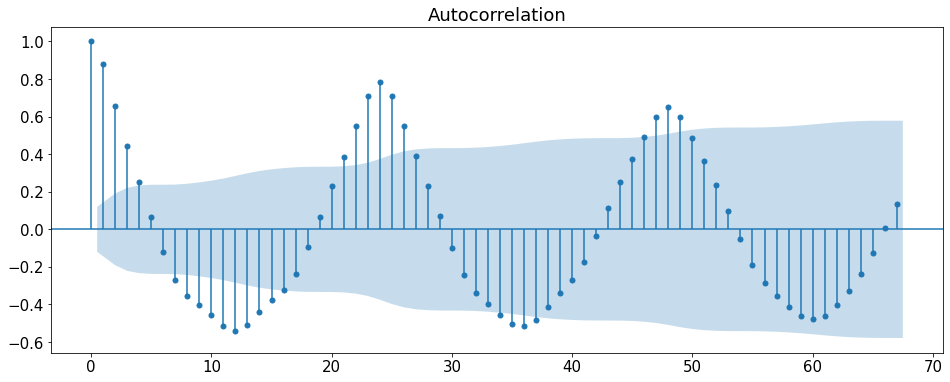

In [28]:
lags = train_steps / 4
plot_pacf(train_data.check_ins, lags=lags) # p
plt.savefig("../../figures/sarima_pacf_%s_steps.pdf"%test_steps, bbox_inches="tight")
plot_acf(train_data.check_ins, lags=lags) # q, S, P, Q
plt.savefig("../../figures/sarima_acf_%s_steps.pdf"%test_steps, bbox_inches="tight")
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 1`
* `q = 3` or `q = 4`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

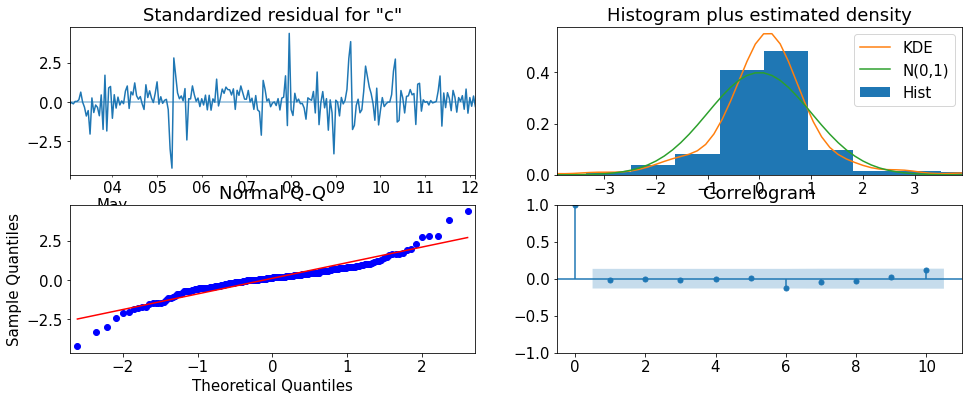

In [29]:
order = (1,0,3)
seasonal_order = (2,0,1,24)

sarima = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima.fit()
sarima_fit.summary()

sarima_fit.plot_diagnostics()
plt.savefig("../../figures/sarima_diagnostics.pdf", bbox_inches="tight")
plt.show()

sarima_predictions = sarima_fit.predict(
    start=test_data.index.min(), end=test_data.index.max(), dynamic=True
).to_frame()

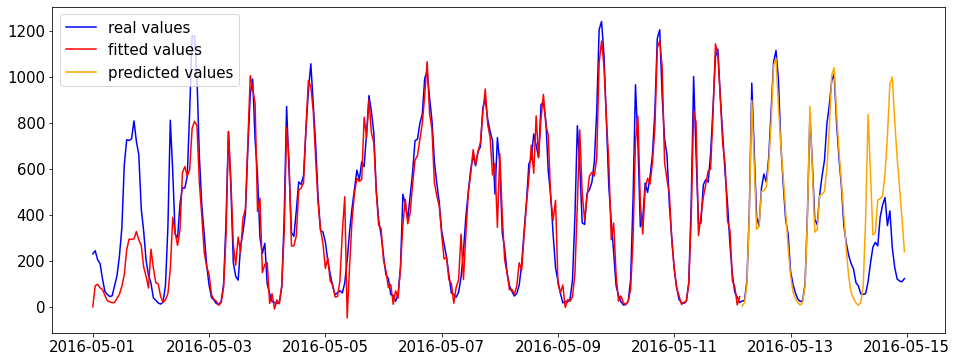

In [30]:
plt.plot(sample_df, color="blue", label="real values")
plt.plot(sarima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions, color="orange", label="predicted values")
plt.legend()
plt.savefig("../../figures/sarima_predictions_%s_steps.pdf"%test_steps, bbox_inches="tight")
plt.show()

In [31]:
print_statistics()

Order: (1, 0, 3)
Seasonal order: (2, 0, 1, 24)
DF steps: 336
Train steps: 268
Test steps: 68
MAPE: 0.7019573803873116
RMSE: 209.53856366866782
MedAE: 41.31597769483665
Max error: 742.9020117057337
R2 score: 0.5199511333846867


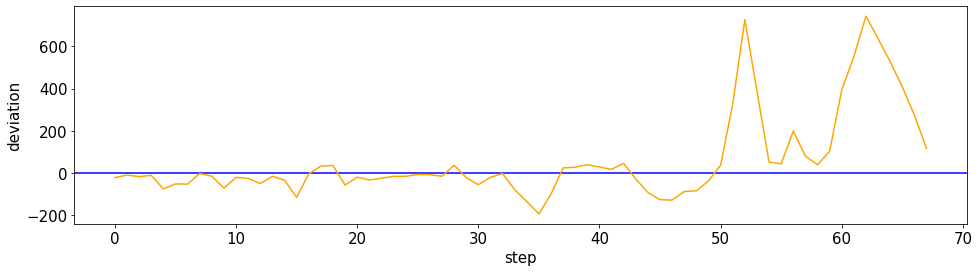

In [32]:
errors = sarima_predictions.predicted_mean.values - test_data.check_ins.values
plt.figure(figsize=(16,4))
plt.axhline(0, color="blue")
plt.plot(errors, color="orange")
plt.xlabel("step")
plt.ylabel("deviation")
plt.savefig("../../figures/sarima_predictions_errors_%s_steps.pdf"%test_steps, bbox_inches="tight")
plt.show()